In [1]:
import os
import argparse
import time
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn        #for all Neural Network stuff
import torch.optim as optim  #for all optimizer stuff

In [2]:
#method argument not needed??
data_size = 1000 #number of points in linspace
batch_time = 20 #number of points in the interval after a random starting point
batch_size = 500 #number of intervals
niters = 2000 #number of iterations
test_freq = 10
viz = True
gpu = 1
adjoint = True

In [3]:
from torchdiffeq import odeint_adjoint as odeint

In [4]:
device = torch.device('cuda:' + str(gpu) if torch.cuda.is_available() else 'cpu')

In [5]:
#create linspace like usual
t = torch.linspace(0.0, 25.0, data_size)
#creates a system of differential equations for dy and dx
true_A = torch.tensor([[-0.1,2.0],[-2.0, -0.1]]) # will generate 2 right hand side second order DE's

In [6]:
def random():
    rand = 0
    while abs(rand) < 1 or abs(rand) > 3:
        rand = np.random.normal(0, 1.5, 1)[0]
    return rand

In [7]:
#lambda is a nn.Module like Linear, Conv2D etc,,
class Lambda(nn.Module):
    def forward(self,t,y):
        return torch.mm(y**3,true_A) #< is the same as below
        #return torch.tensor([-0.1*y[:,0]**3-2*y[:,1]**3,2*y[:,0]**3-0.1*y[:,1]**3])  #starting with true_y0 it does mxn X nxp -> mxp

In [8]:
def get_batch():
    s = torch.from_numpy(np.random.choice(np.arange(data_size-batch_time, dtype=np.int64), batch_size, replace=False))
#s is a torch tensor from a numpy array. the array is a random choice array, a rand number from 0 to ds-bt is chosen bs times.
#s has batch_size elements and each was equally likely to be chosen
#why ds-bt? why not just data_size as a rance since we are chosing from the t linspace with ds many points?
#it does ds-bt so that when it chooses the next bt number of points we will never fall out of the index range if
#    ds=1000 and bt=10 then then if i start at 990, I will end up with 990-1000 and not over.
    batch_y0 = true_y[s] #(M, D) <- idk what this means
#b_y0 is made of the randomly selected data points (dep vals) from true_y solution
    batch_t = t[:batch_time] #(T)
#b_t is the values rank 0 to b_time from your linspace t; the linspace values being looked at
    batch_y = torch.stack([true_y[s+i] for i in range(batch_time)],dim=0)  # (T, M, D)
    return batch_y0, batch_t, batch_y


In [9]:
def makedirs(dirname):
    if not os.path.exists(dirname):
        os.makedirs(dirname)

In [10]:
def drawDFT(ySpace, length, function):
    for l in ySpace:
        for k in ySpace:
            y = torch.tensor([[l,k]])
            t = torch.tensor([[]])
            #direction i and j + Magnitude of <i,j>
            i = function.forward(t,y)[:,0][0].numpy()
            j = function.forward(t,y)[:,1][0].numpy()
            magnitude = np.sqrt(i**2+j**2)
            
            #normalize and scale by h
            i = h*i/magnitude
            j = h*j/magnitude
            
            current_domain = np.linspace(l-(i/2), l+(i/2), 2) #the end points of the small intervals
            current_range = np.linspace(k-(j/2), k+(j/2), 2)

            plt.plot(current_domain, current_range, lw=0.2, color='b')
            plt.arrow(current_domain[0],current_range[0], i, j, color='b', lw=0.5, length_includes_head=True, head_length=0.1, head_width=0.1)

In [11]:
def visualize(true_y, pred_y, y_space, length, function):
    b = y_space[y_space.size-1]
    a = y_space[0]
    
    #Draw True Y
    drawDFT(y_space, length, Lambda())
    plt.plot(true_y.numpy()[:, 0, 0], true_y.numpy()[:, 0, 1],'r--')
    plt.xlim(a,b)
    plt.ylim(a,b)
    plt.savefig('png/{:03d}'.format(itr))
    plt.show()
    
    #Draw Pred Y
    drawDFT(y_space, length, function)
    plt.plot(pred_y.numpy()[:, 0, 0], pred_y.numpy()[:, 0, 1],'m--')
    plt.xlim(a,b)
    plt.ylim(a,b)
    plt.savefig('png/{:03d}'.format(itr))
    plt.show()

In [12]:
class ODEFunc(nn.Module): #create an ODE block as our neural network. usually multiple layers/modules
    
    def __init__(self):
        super(ODEFunc, self).__init__()
#self.net is the neural network layers one after the other L -> T -> L        
        self.net = nn.Sequential(    
            nn.Linear(2,50),
            nn.Tanh(),
            nn.Linear(50,2),
        )
        
        for m in self.net.modules():
            if isinstance(m,nn.Linear): #checks in the module m in self.net is an instance of the nn.Linear class
                nn.init.normal_(m.weight, mean=0, std=0.1) #for the Linear modules make all the weights randn with std 0.1
                nn.init.constant_(m.bias, val=0) #for the Linear modules make all the bias vector values 0
    
    def forward(self, t, y):
        return self.net(y**3) #essentially Lambda.forward(args) without the true_A >>>which is TBD<<<

In [13]:
class RunningAverageMeter(object): #Computes and stores the average and current value
    def __init__(self, momentum=0.99): #new object of this class will have mom of 0.99 and a reset val and avg
        self.momentum = momentum
        self.reset()
    def reset(self):                   #reset function called to set val and avg to None and 0 respectively
        self.val = None
        self.avg = 0
    def update(self, val):             #update is called externally to update the avg based on val
        if self.val is None:
            self.avg = val
        else:
            self.avg = (self.avg * self.momentum) + (val * (1 - self.momentum)) #reminds me of output error at L

Iteration 0001 | Total Loss 0.832993
Iteration 0002 | Total Loss 0.694263
Iteration 0003 | Total Loss 0.595261
Iteration 0004 | Total Loss 0.620153
Iteration 0005 | Total Loss 0.665977
Iteration 0006 | Total Loss 0.518862
Iteration 0007 | Total Loss 0.680788
Iteration 0008 | Total Loss 0.604130
Iteration 0009 | Total Loss 0.699326
Iteration 0010 | Total Loss 0.627656


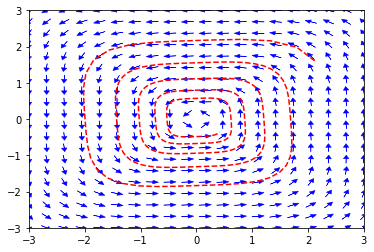

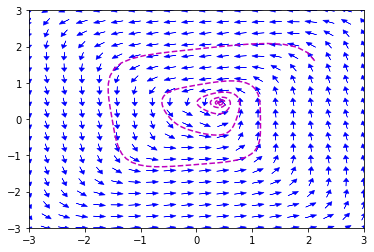

Iteration 0011 | Total Loss 0.630533
Iteration 0012 | Total Loss 0.569068
Iteration 0013 | Total Loss 0.629620
Iteration 0014 | Total Loss 0.457374
Iteration 0015 | Total Loss 0.522538
Iteration 0016 | Total Loss 0.666757
Iteration 0017 | Total Loss 0.636527
Iteration 0018 | Total Loss 0.658543
Iteration 0019 | Total Loss 0.483213
Iteration 0020 | Total Loss 0.453152


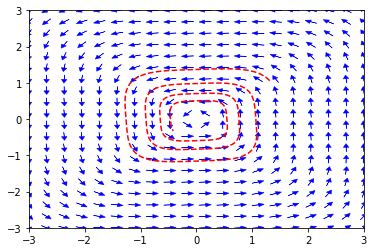

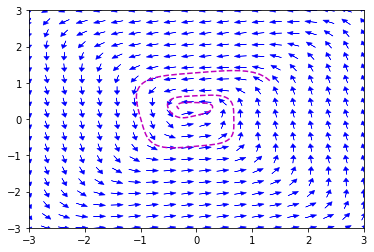

Iteration 0021 | Total Loss 0.553086
Iteration 0022 | Total Loss 0.591687
Iteration 0023 | Total Loss 0.599168
Iteration 0024 | Total Loss 0.651728
Iteration 0025 | Total Loss 0.498915
Iteration 0026 | Total Loss 0.707727
Iteration 0027 | Total Loss 0.578136
Iteration 0028 | Total Loss 0.745688
Iteration 0029 | Total Loss 0.467494
Iteration 0030 | Total Loss 0.527007


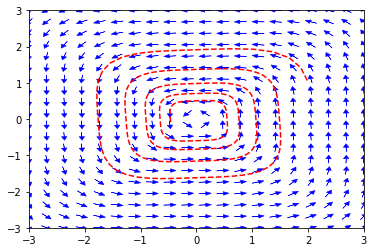

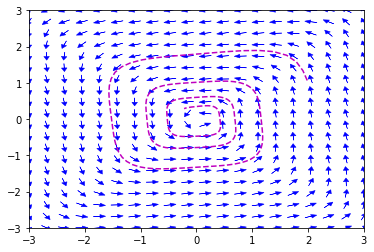

Iteration 0031 | Total Loss 0.593900
Iteration 0032 | Total Loss 0.499206
Iteration 0033 | Total Loss 0.549072
Iteration 0034 | Total Loss 0.971702
Iteration 0035 | Total Loss 0.520455
Iteration 0036 | Total Loss 1.260961
Iteration 0037 | Total Loss 0.521304
Iteration 0038 | Total Loss 0.456149
Iteration 0039 | Total Loss 0.467295
Iteration 0040 | Total Loss 0.629249


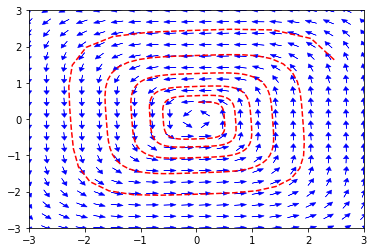

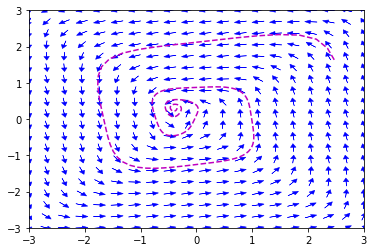

Iteration 0041 | Total Loss 0.430868
Iteration 0042 | Total Loss 0.679289
Iteration 0043 | Total Loss 0.824530
Iteration 0044 | Total Loss 0.449715
Iteration 0045 | Total Loss 0.653787
Iteration 0046 | Total Loss 0.703452
Iteration 0047 | Total Loss 0.669376
Iteration 0048 | Total Loss 0.536223
Iteration 0049 | Total Loss 0.667062
Iteration 0050 | Total Loss 0.589685


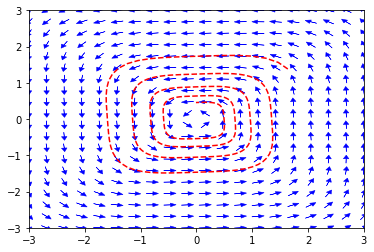

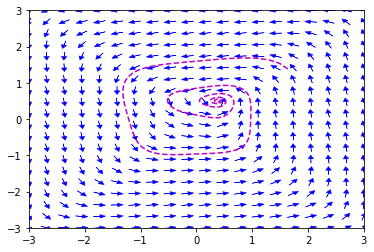

Iteration 0051 | Total Loss 1.403981
Iteration 0052 | Total Loss 0.565626
Iteration 0053 | Total Loss 0.598640
Iteration 0054 | Total Loss 0.685319
Iteration 0055 | Total Loss 0.586829
Iteration 0056 | Total Loss 0.456356
Iteration 0057 | Total Loss 0.628964
Iteration 0058 | Total Loss 0.536481
Iteration 0059 | Total Loss 0.497962
Iteration 0060 | Total Loss 0.644024


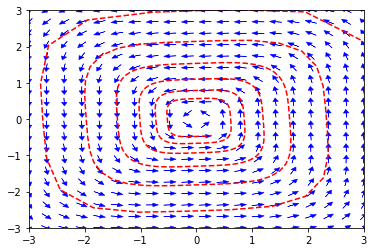

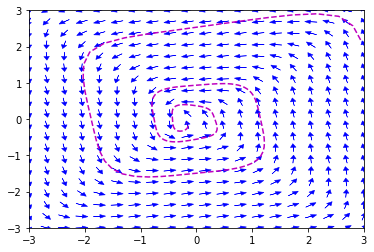

Iteration 0061 | Total Loss 0.669599
Iteration 0062 | Total Loss 0.576473
Iteration 0063 | Total Loss 0.451873
Iteration 0064 | Total Loss 0.459958
Iteration 0065 | Total Loss 0.883687
Iteration 0066 | Total Loss 0.638958
Iteration 0067 | Total Loss 0.583010
Iteration 0068 | Total Loss 0.593046
Iteration 0069 | Total Loss 0.490614
Iteration 0070 | Total Loss 0.669763


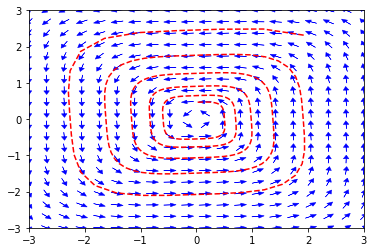

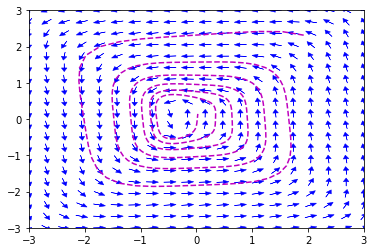

Iteration 0071 | Total Loss 0.599132
Iteration 0072 | Total Loss 0.671053
Iteration 0073 | Total Loss 0.437272
Iteration 0074 | Total Loss 0.573493
Iteration 0075 | Total Loss 0.600550
Iteration 0076 | Total Loss 1.086924
Iteration 0077 | Total Loss 0.637361
Iteration 0078 | Total Loss 0.526126
Iteration 0079 | Total Loss 0.571402
Iteration 0080 | Total Loss 0.467572


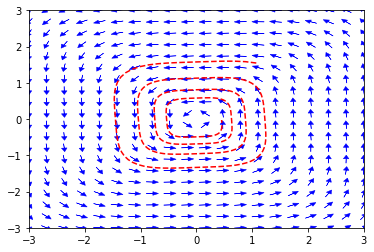

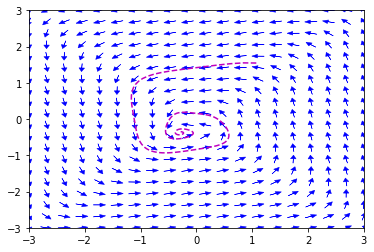

Iteration 0081 | Total Loss 0.871477
Iteration 0082 | Total Loss 0.563360
Iteration 0083 | Total Loss 0.658859
Iteration 0084 | Total Loss 0.511604
Iteration 0085 | Total Loss 0.588762
Iteration 0086 | Total Loss 1.368942
Iteration 0087 | Total Loss 0.558895
Iteration 0088 | Total Loss 0.765069
Iteration 0089 | Total Loss 0.672763
Iteration 0090 | Total Loss 0.754826


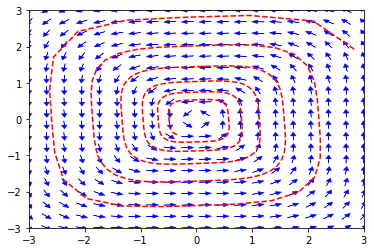

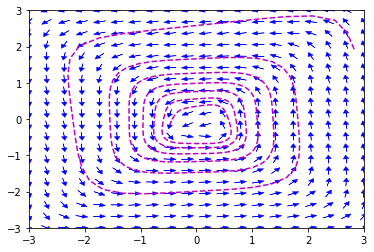

Iteration 0091 | Total Loss 0.586648
Iteration 0092 | Total Loss 0.506648
Iteration 0093 | Total Loss 0.517081
Iteration 0094 | Total Loss 0.603518
Iteration 0095 | Total Loss 0.604277
Iteration 0096 | Total Loss 0.511897
Iteration 0097 | Total Loss 1.489828
Iteration 0098 | Total Loss 0.554920
Iteration 0099 | Total Loss 0.642342
Iteration 0100 | Total Loss 0.406878


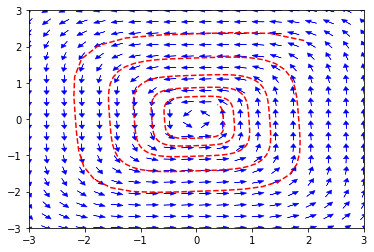

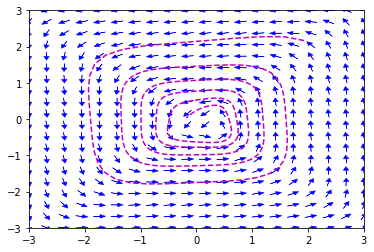

Iteration 0101 | Total Loss 0.652830
Iteration 0102 | Total Loss 0.582666
Iteration 0103 | Total Loss 0.580792
Iteration 0104 | Total Loss 0.608839
Iteration 0105 | Total Loss 0.582075
Iteration 0106 | Total Loss 0.739011
Iteration 0107 | Total Loss 0.532781
Iteration 0108 | Total Loss 0.606371
Iteration 0109 | Total Loss 0.595503
Iteration 0110 | Total Loss 0.615562


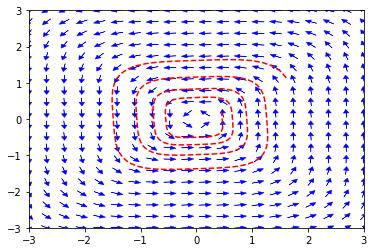

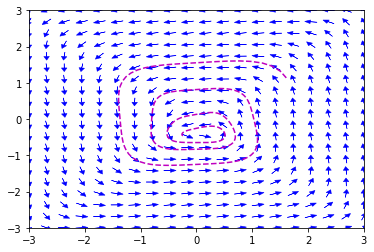

Iteration 0111 | Total Loss 0.578436
Iteration 0112 | Total Loss 1.361566
Iteration 0113 | Total Loss 0.580031
Iteration 0114 | Total Loss 0.521301
Iteration 0115 | Total Loss 0.722653
Iteration 0116 | Total Loss 0.552659
Iteration 0117 | Total Loss 0.598502
Iteration 0118 | Total Loss 0.570831
Iteration 0119 | Total Loss 0.510697
Iteration 0120 | Total Loss 1.264256


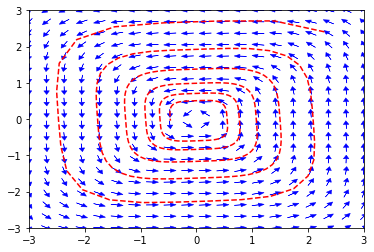

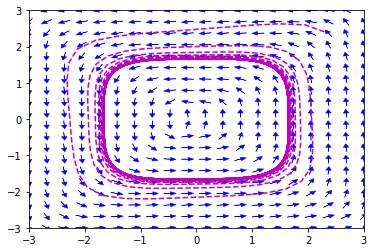

Iteration 0121 | Total Loss 0.562045
Iteration 0122 | Total Loss 0.527814
Iteration 0123 | Total Loss 0.552831
Iteration 0124 | Total Loss 0.554668
Iteration 0125 | Total Loss 0.518258
Iteration 0126 | Total Loss 0.526428
Iteration 0127 | Total Loss 0.630247
Iteration 0128 | Total Loss 1.270519
Iteration 0129 | Total Loss 0.496852
Iteration 0130 | Total Loss 0.684747


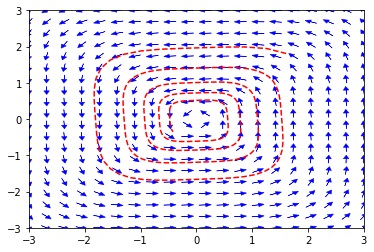

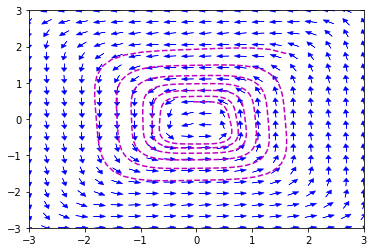

Iteration 0131 | Total Loss 0.308688
Iteration 0132 | Total Loss 1.181825
Iteration 0133 | Total Loss 0.569932
Iteration 0134 | Total Loss 0.577473
Iteration 0135 | Total Loss 0.599270
Iteration 0136 | Total Loss 0.484483
Iteration 0137 | Total Loss 0.202698
Iteration 0138 | Total Loss 0.830657
Iteration 0139 | Total Loss 0.303377
Iteration 0140 | Total Loss 0.212178


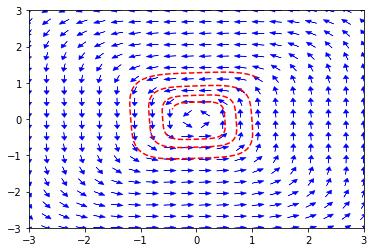

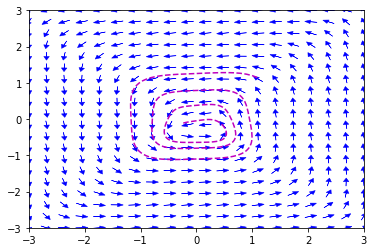

Iteration 0141 | Total Loss 0.648394
Iteration 0142 | Total Loss 0.511387
Iteration 0143 | Total Loss 1.573079
Iteration 0144 | Total Loss 0.643509
Iteration 0145 | Total Loss 0.541614
Iteration 0146 | Total Loss 0.560813
Iteration 0147 | Total Loss 0.520738
Iteration 0148 | Total Loss 0.703054
Iteration 0149 | Total Loss 0.538966
Iteration 0150 | Total Loss 0.617605


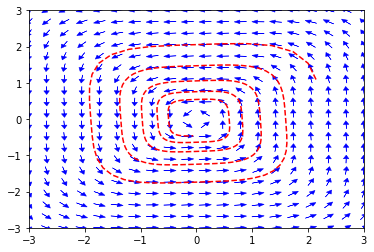

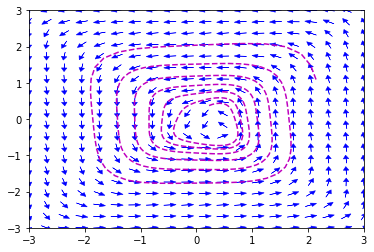

Iteration 0151 | Total Loss 0.520900


KeyboardInterrupt: 

In [14]:
if __name__ == '__main__':
    
    #ii = 0
    
    Y = torch.linspace(-3,3,20)
    h = 0.22
    
    func = ODEFunc()
    optimizer = optim.RMSprop(func.parameters())          #this is an optimizer designed to update parameters
    end = time.time()                                     #usually people use SGD but this is a mini-batch approach
                                                          #http://www.cs.toronto.edu/~tijmen/csc321/slides/lecture_slides_lec6.pdf
    #RunningAvgMeter Objects
    time_meter = RunningAverageMeter(0.97)
    loss_meter = RunningAverageMeter(0.97)
    
    #TRAINING
    for itr in range(1, niters+1):
        
        #initial conditions; requires 2D tensor
        true_y0 = torch.tensor([[random(),random()]])

        with torch.no_grad(): #no_grad disables gradient finding when true_y is defined
            #print(torch.mm(true_y0**3,true_A))
            true_y = odeint(Lambda(),true_y0, t, method='adams') 
            #true_y is the solved ODE defined in Lambda
            #odeint only takes a function from nn.Module >> implications? see solver comparision Jupyter
            #it uses Lambda to provide the function to go solve the IVP given true_y0 with the ODE solver on t

        
        optimizer.zero_grad() #set gradients to zero/ not computed
        batch_y0, batch_t, batch_y = get_batch()
        #feeds odeint the ODEBlock, a set of y values based on random t values and the first ten values of t
        pred_y = odeint(func, batch_y0, batch_t)
        #deviates from usual Loss of mean squared difference but sum in both cases is positive
        loss = torch.mean(torch.abs(pred_y-batch_y)**2) #ask Ivan about predY-bY, also this returns a number
        
        loss.backward() #backpropogation
        optimizer.step() #gradient descent and update parameters
    
        #Update time and loss meters
        time_meter.update(time.time()-end) #takes in time difference to establish velocity see RMS method details
        loss_meter.update(loss.item()) #the loss itself is a delta / change
        
        with torch.no_grad():
            pred_y = odeint(func, true_y0, t)
            loss = torch.mean(torch.abs(pred_y-true_y))
            print('Iteration {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))
        
            if itr % test_freq == 0:
                visualize(true_y,pred_y, Y.numpy(), h, func)
                
        end = time.time()